# CSO QaQc: Conclusions and Analysis

Here I will go over findings and insights from my QaQc of the data across multiple notebooks. I will take time to talk about and show my findings. This notebook will also be a place for me to conduct some statistical tests on the data so we can make quantitative conclusions on parts of the data.

In [1]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

# Import necessary packages, may need more or less as I go.

In [2]:
CSO_gdf = gpd.read_file('CSOgeodata.geojson')
CSO_gdf['timestamp'] = pd.to_datetime(CSO_gdf.timestamp)
CSO_gdf['flags'] = False
CSO_gdf.head(10)

,id,author,depth,source,timestamp,elevation,geometry,flags
0,4J5z5w7h,camila chamizo,150.0,SnowPilot,2021-06-28 20:15:00+00:00,1881.618530,POINT (-71.56655 -41.10209),False
1,2C8R7ehK,camila chamizo,150.0,SnowPilot,2021-06-28 18:15:00+00:00,1881.618530,POINT (-71.56655 -41.10209),False
2,a3a3VCXY,juan manuel raselli,155.0,SnowPilot,2021-06-26 20:00:00+00:00,1577.167603,POINT (-72.93703 -49.07451),False
3,ImH60r2U,John Soltys,90.0,MountainHub,2021-06-26 15:12:30.931999+00:00,1585.094727,POINT (-121.40983 47.45218),False
4,mebZPRGY,Roberto indio Treu,400.0,SnowPilot,2021-06-25 15:00:00+00:00,1568.316284,POINT (-72.93789 -49.07159),False
5,es0SceGk,juan manuel raselli,135.0,SnowPilot,2021-06-24 22:00:00+00:00,1310.907715,POINT (-72.92399 -49.07053),False
6,cDke3Yv1,David Lundin,47.0,SnowPilot,2021-06-23 17:00:00+00:00,1844.694214,POINT (168.93805 -44.85328),False
7,h5jx/c96,David Lundin,55.0,SnowPilot,2021-06-23 17:00:00+00:00,1836.381592,POINT (168.94681 -44.85560),False
8,3BIc0jAn,George Loomes,120.0,SnowPilot,2021-06-23 00:30:00+00:00,1894.013428,POINT (170.33054 -43.73712),False
9,nb5UvScN,John Soltys,130.0,MountainHub,2021-06-20 17:21:45.983002+00:00,1822.853027,POINT (-121.50287 46.86515),False


# Data from MountainHub

We'll be looking into values specific to `MountianHub` as those are the most likely to have some form of QaQc failure due to the self reporting nature of it. `SnowPilot` is much more rigorous in its data collection.

I'll be analyizing and comparing `MountainHub` through 3 different lenses:

* General Distribution of the `MountainHub` data and how it compares to all the data and specific sources.

* Small depth values close to `0 cm`. Zero values are interesting values to look at in the data as it appears quite often in many different areas and has a sizeable influence on an areas over all snow quality and depth. We have a discrepnacy with these values in `SnowPilot` so it will be interesting to see where `MountainHub` stands.

* Large depth values over `300 cm`. This is the theoretical maximum for most recreational skiers due to snow probe constraints so I would like to see how this compares to the other sources and data as a whole.

At the end of this notebook I'll provide some form of roadmap on a possible quality checks we could assign to the database to flag specific values that may be erronious or at the very least suspicious. These quality checks will have to catered to the specific source as `MountainHub` and `SnowPilot` have their own share of quircks and possible issues.

# General Distributions

I'll be constructing a few plots for qualitative assessments of the data and than doing statistics on `MountainHub` with respect to the rest of the data. This will help preface a lot of what we've been working on in multiple notebooks and what we'll be highlighting in this notebook.

In [3]:
CSO_gdf.describe()

,depth,elevation
count,30497.000000,30497.000000
mean,105.028916,1209.759659
std,86.295661,966.930380
min,0.000000,0.000000
25%,40.000000,483.760162
50%,94.000000,907.063049
75%,150.000000,1861.142090
max,1176.000000,4614.939453


In [4]:
CSO_gdf.loc[CSO_gdf['source'] == "MountainHub", 'flags'] = True
CSO_MH = (CSO_gdf.loc[CSO_gdf['flags'] == True])
CSO_MH.describe()

,depth,elevation
count,4663.000000,4663.000000
mean,120.274660,1322.582082
std,99.741173,903.036526
min,0.000000,0.010386
25%,50.000000,569.156372
50%,94.000000,1119.703003
75%,165.000000,2056.575073
max,998.219985,3960.614014


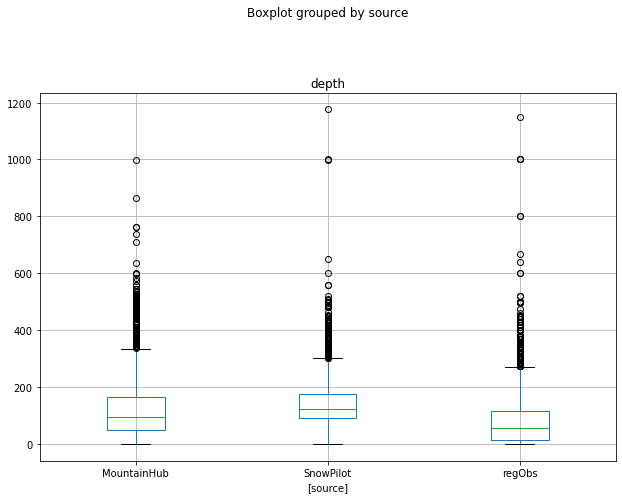

In [5]:
boxplots = CSO_gdf.boxplot(column=['depth'], by=['source'],layout=(2, 1), figsize = (10,15))

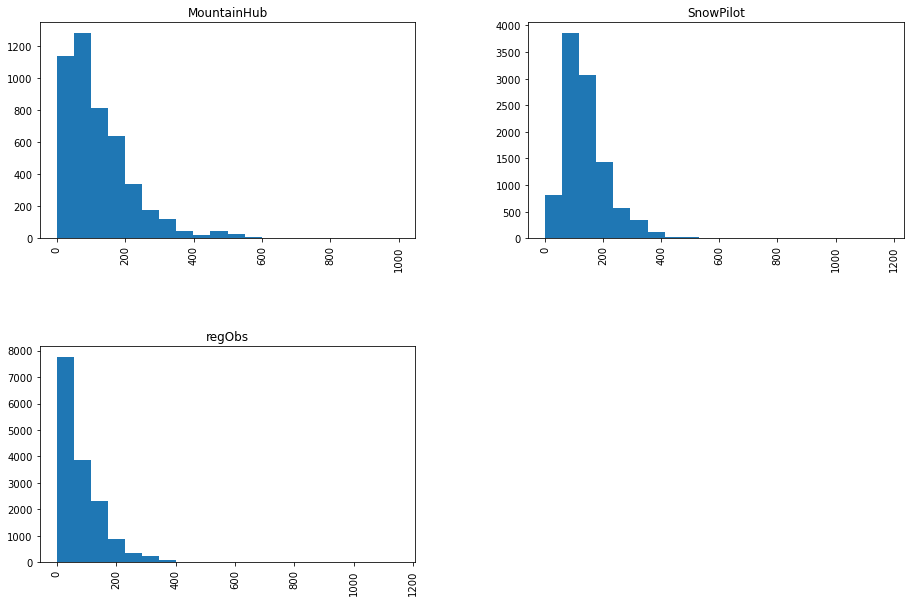

In [6]:
histogram_gdf = CSO_gdf['depth'].hist(by= CSO_gdf['source'], bins = 20, figsize= (15,10))

In [7]:
CSO_gdf[['source', 'depth']].groupby(['source']).agg(['count', 'min', 'max'])

depth                  
             count  min          max
source                              
MountainHub   4663  0.0   998.219985
SnowPilot    10278  0.0  1176.000000
regObs       15556  0.1  1150.000000

We can see from just visual analysis, that `MountainHub` has much more variability than `SnowPilot` which makes a lot of sense. Variability isn't necessarily a bad thing and even in this case it can be a good thing when it comes to having data from a multitude of places and people. I think this sets up the rest of our anaylsis.

# Small Depth Values

Building off of much of the information in `CSOZeros.ipynb` but now mainly focused on how `MountainHub` compares to the rest of the data. Small depth values are very interesting especially with the inconsistencies revolving around `SnowPilot`. It's a way for us to look at one of the 2 extremes for data collection and to see how the Citizen Science data collection compares to more contained forms of data aquisition. 